#Import Packages#

In [ ]:
!pip install linear-tree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import sklearn, numpy, joblib, imblearn

from collections import Counter
from sklearn import preprocessing, svm
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from lineartree import LinearForestClassifier, LinearBoostClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Import/Inspection/Cleaning#

In [111]:
clinicalData = pd.read_csv("/content/drive/MyDrive/HIDS 509/Project/TCGA Clinical Data/2022_TCGA_GBM_LGG_clinical_231patients.csv")
cliniccalFeatures = pd.read_csv("/content/drive/MyDrive/HIDS 509/Project/TCGA PyRadiomics/TCGA Data for main task/TCGA_pyradiomics_t1.csv")

df = cliniccalFeatures.merge(clinicalData, left_on = "ID", right_on = "Row.names")

#Initial feature selection
removedFeatures = ["diagnostics_Configuration_EnabledImageTypes", "diagnostics_Configuration_Settings", "diagnostics_Image-original_Hash", 
                   "diagnostics_Image-original_Maximum", "diagnostics_Image-original_Mean", "diagnostics_Image-original_Minimum", 
                   "diagnostics_Image-original_Size", "diagnostics_Image-original_Spacing", "diagnostics_Mask-original_BoundingBox", 
                   "diagnostics_Mask-original_VolumeNum", "diagnostics_Mask-original_VoxelNum", "diagnostics_Mask-original_CenterOfMass",
                   "diagnostics_Mask-original_CenterOfMassIndex", "diagnostics_Mask-original_Hash", "diagnostics_Mask-original_Size", 
                   "diagnostics_Mask-original_Spacing", "diagnostics_Versions_Numpy", "ID", 
                   "diagnostics_Versions_PyRadiomics", "diagnostics_Versions_PyWavelet", "diagnostics_Versions_Python", 
                   "diagnostics_Versions_SimpleITK", "Source", "Row.names", "Gender", "Race", "diagnostics_Image-original_Dimensionality"]

df = df.drop(removedFeatures, axis=1)
df.columns

Index(['original_firstorder_10Percentile', 'original_firstorder_90Percentile',
       'original_firstorder_Energy', 'original_firstorder_Entropy',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_Mean', 'original_firstorder_MeanAbsoluteDeviation',
       'original_firstorder_Median',
       ...
       'original_shape_Maximum2DDiameterRow',
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume',
       'original_shape_MinorAxisLength', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio',
       'original_shape_VoxelVolume', 'Disease_Type'],
      dtype='object', length=108)

In [112]:
df.head()

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,...,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,Disease_Type
0,246.0,291.0,3.119856e+08,1.669089,24.0,3.456869,338.0,267.256611,14.005987,266.0,...,31.048349,33.286634,36.249138,4240.375000,21.857589,0.353025,3588.790560,0.846338,4349.0,GBM
1,181.0,236.0,2.151917e+09,1.866797,26.0,3.479689,304.0,209.331125,16.333261,210.0,...,92.763139,70.228199,104.278473,48177.250000,52.467970,0.348870,18353.330279,0.380954,48610.0,GBM
2,1082.0,1539.0,1.301408e+10,4.789586,225.0,3.227854,2009.0,1297.986820,136.890905,1293.0,...,40.311289,47.010637,47.968740,7196.875000,23.419801,0.398880,4519.303940,0.627954,7587.0,GBM
3,220.0,256.0,4.046741e+08,1.515616,16.0,7.582218,287.0,237.074121,14.360990,242.0,...,38.948684,38.910153,41.821047,7054.375000,27.698853,0.493544,3604.103902,0.510903,7137.0,GBM
4,350.0,442.0,3.925545e+09,2.554710,44.0,5.043379,593.0,391.181460,29.580972,384.0,...,63.906181,59.304300,65.513357,24665.333333,34.936751,0.314533,13027.933797,0.528188,25394.0,GBM


In [113]:
df = df.drop(df[df.Disease_Type == "Oligoastrocytoma"].index)
df.dtypes[df.dtypes != "float64"]

Disease_Type    object
dtype: object

In [114]:
df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace = True)
df.columns[df.isnull().any()]

Index([], dtype='object')

In [115]:
X = df.drop(["Disease_Type"], axis = 1)
y = df["Disease_Type"]
Counter(y)

Counter({'GBM': 91, 'Astrocytoma': 21, 'Oligodendroglioma': 26})

In [116]:
le = preprocessing.LabelEncoder().fit(["GBM", "Astrocytoma", "Oligodendroglioma"])
y = le.transform(y)
Counter(y)

Counter({1: 91, 0: 21, 2: 26})

In [117]:
feature_selector = SelectKBest(mutual_info_classif, k = 10).fit(X, y).get_feature_names_out(df.drop(["Disease_Type"], axis = 1).columns)
X = df[feature_selector]
feature_selector

array(['original_glrlm_GrayLevelNonUniformity',
       'original_glrlm_HighGrayLevelRunEmphasis',
       'original_glrlm_LongRunHighGrayLevelEmphasis',
       'original_glrlm_RunEntropy',
       'original_glrlm_ShortRunLowGrayLevelEmphasis',
       'original_glszm_GrayLevelNonUniformity', 'original_ngtdm_Busyness',
       'original_shape_MeshVolume', 'original_shape_SurfaceVolumeRatio',
       'original_shape_VoxelVolume'], dtype=object)

In [118]:
X.shape

(138, 10)

In [119]:
scaler = sklearn.preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
filename = "/content/drive/MyDrive/HIDS 509/Project/Models/scaler.bin"
joblib.dump(scaler, filename, compress=True)

X, y = imblearn.over_sampling.ADASYN(sampling_strategy = "not majority", random_state = 50).fit_resample(X, y)
X, y = imblearn.under_sampling.RepeatedEditedNearestNeighbours(sampling_strategy = [1]).fit_resample(X, y)
X, y = imblearn.over_sampling.KMeansSMOTE(sampling_strategy = "not minority", random_state = 50).fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 50)
print(Counter(y))
print(X_train.shape, X_test.shape, y_train.shape, y_test .shape)

Counter({2: 99, 0: 98, 1: 17})
(181, 10) (33, 10) (181,) (33,)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#SVM#

In [ ]:
SVM = svm.SVC(kernel = "poly", degree = 10, random_state = 50)
SVM_model = cross_validate(SVM, X_train, y_train, cv = 3, return_train_score = True, return_estimator = True)
SVM_model["test_score"], SVM_model["train_score"]

(array([0.50819672, 0.63333333, 0.58333333]),
 array([0.59166667, 0.6446281 , 0.6446281 ]))

In [ ]:
for i in range(3): print(classification_report(y_test, SVM_model.get("estimator")[i].predict(X_test), zero_division = 0))

              precision    recall  f1-score   support

           0       1.00      0.18      0.30        17
           1       0.00      0.00      0.00         3
           2       0.43      1.00      0.60        13

    accuracy                           0.48        33
   macro avg       0.48      0.39      0.30        33
weighted avg       0.69      0.48      0.39        33

              precision    recall  f1-score   support

           0       1.00      0.47      0.64        17
           1       0.00      0.00      0.00         3
           2       0.52      1.00      0.68        13

    accuracy                           0.64        33
   macro avg       0.51      0.49      0.44        33
weighted avg       0.72      0.64      0.60        33

              precision    recall  f1-score   support

           0       1.00      0.41      0.58        17
           1       0.00      0.00      0.00         3
           2       0.50      1.00      0.67        13

    accuracy        

In [ ]:
filename = "/content/drive/MyDrive/HIDS 509/Project/Models/SVM.sav"
joblib.dump(SVM_model.get("estimator")[2], filename)

['/content/drive/MyDrive/HIDS 509/Project/Models/SVM.sav']

#Random Forest Classifier#

In [ ]:
RFC = RandomForestClassifier(n_estimators = 500, max_depth = 10, min_samples_leaf = 5, max_features = 5)
RFC_model = cross_validate(RFC, X_train, y_train, cv = 3, return_train_score = True, return_estimator = True)
RFC_model["test_score"], RFC_model["train_score"]

(array([0.75409836, 0.9       , 0.83333333]),
 array([0.96666667, 1.        , 0.97520661]))

In [ ]:
for i in range(3): print(classification_report(y_test, RFC_model.get("estimator")[i].predict(X_test), zero_division = 0))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84        17
           1       1.00      0.67      0.80         3
           2       0.80      0.62      0.70        13

    accuracy                           0.79        33
   macro avg       0.85      0.74      0.78        33
weighted avg       0.80      0.79      0.78        33

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        17
           1       1.00      1.00      1.00         3
           2       1.00      0.77      0.87        13

    accuracy                           0.91        33
   macro avg       0.95      0.92      0.93        33
weighted avg       0.92      0.91      0.91        33

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        17
           1       1.00      0.33      0.50         3
           2       0.67      0.77      0.71        13

    accuracy        

In [ ]:
filename = "/content/drive/MyDrive/HIDS 509/Project/Models/RFC.sav"
joblib.dump(RFC_model.get("estimator")[1], filename)

['/content/drive/MyDrive/HIDS 509/Project/Models/RFC.sav']

In [ ]:
for i in range(3):
    print(pd.DataFrame({"feature": list(feature_selector), "importance": RFC_model.get("estimator")[i].feature_importances_}).sort_values("importance", ascending=False)[:10])

                                       feature  importance
5        original_glszm_GrayLevelNonUniformity    0.226819
2  original_glrlm_LongRunHighGrayLevelEmphasis    0.178774
8            original_shape_SurfaceVolumeRatio    0.165986
3                    original_glrlm_RunEntropy    0.145455
4  original_glrlm_ShortRunLowGrayLevelEmphasis    0.066358
1      original_glrlm_HighGrayLevelRunEmphasis    0.060471
6                      original_ngtdm_Busyness    0.053653
0        original_glrlm_GrayLevelNonUniformity    0.042939
7                    original_shape_MeshVolume    0.030724
9                   original_shape_VoxelVolume    0.028820
                                       feature  importance
8            original_shape_SurfaceVolumeRatio    0.172608
2  original_glrlm_LongRunHighGrayLevelEmphasis    0.157769
3                    original_glrlm_RunEntropy    0.141562
5        original_glszm_GrayLevelNonUniformity    0.133770
0        original_glrlm_GrayLevelNonUniformity    0.1050

#Bagging Classifier#

In [ ]:
BC = BaggingClassifier(estimator = sklearn.tree.ExtraTreeClassifier(min_samples_split = 5, random_state = 50), n_estimators = 5)
BC_model = cross_validate(BC, X_train, y_train, cv = 3, return_train_score = True, return_estimator = True)
BC_model["test_score"], BC_model["train_score"]

(array([0.83606557, 0.83333333, 0.78333333]),
 array([0.95      , 0.95867769, 0.95867769]))

In [ ]:
for i in range(3): print(classification_report(y_test, BC_model.get("estimator")[i].predict(X_test), zero_division = 0))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71        17
           1       1.00      0.67      0.80         3
           2       0.64      0.69      0.67        13

    accuracy                           0.70        33
   macro avg       0.78      0.69      0.72        33
weighted avg       0.71      0.70      0.70        33

              precision    recall  f1-score   support

           0       0.79      0.88      0.83        17
           1       1.00      0.67      0.80         3
           2       0.75      0.69      0.72        13

    accuracy                           0.79        33
   macro avg       0.85      0.75      0.78        33
weighted avg       0.79      0.79      0.79        33

              precision    recall  f1-score   support

           0       0.87      0.76      0.81        17
           1       1.00      0.33      0.50         3
           2       0.65      0.85      0.73        13

    accuracy        

In [ ]:
filename = "/content/drive/MyDrive/HIDS 509/Project/Models/BC.sav"
joblib.dump(BC_model.get("estimator")[1], filename)

['/content/drive/MyDrive/HIDS 509/Project/Models/BC.sav']

#AdaBoost Classifier#

In [ ]:
ABC = AdaBoostClassifier(n_estimators = 25)
ABC_model = cross_validate(ABC, X_train, y_train, cv = 3, return_train_score = True, return_estimator = True)
ABC_model["test_score"], ABC_model["train_score"]

(array([0.57377049, 0.5       , 0.6       ]),
 array([0.575     , 0.61983471, 0.63636364]))

In [ ]:
for i in range(3): print(classification_report(y_test, ABC_model.get("estimator")[i].predict(X_test), zero_division = 0))

              precision    recall  f1-score   support

           0       0.60      0.18      0.27        17
           1       0.50      1.00      0.67         3
           2       0.36      0.62      0.46        13

    accuracy                           0.42        33
   macro avg       0.49      0.60      0.47        33
weighted avg       0.50      0.42      0.38        33

              precision    recall  f1-score   support

           0       0.57      0.24      0.33        17
           1       0.40      0.67      0.50         3
           2       0.38      0.62      0.47        13

    accuracy                           0.42        33
   macro avg       0.45      0.51      0.43        33
weighted avg       0.48      0.42      0.40        33

              precision    recall  f1-score   support

           0       0.59      0.94      0.73        17
           1       1.00      0.67      0.80         3
           2       0.50      0.15      0.24        13

    accuracy        

In [ ]:
filename = "/content/drive/MyDrive/HIDS 509/Project/Models/ABC.sav"
joblib.dump(ABC_model.get("estimator")[2], filename)

['/content/drive/MyDrive/HIDS 509/Project/Models/ABC.sav']

In [ ]:
cols = df.drop(["Disease_Type"], axis = 1).columns
for i in range(3):
    print(pd.DataFrame({"feature": list(feature_selector), "importance": ABC_model.get("estimator")[i].feature_importances_}).sort_values("importance", ascending=False)[:10])

                                       feature  importance
3                    original_glrlm_RunEntropy        0.48
8            original_shape_SurfaceVolumeRatio        0.48
2  original_glrlm_LongRunHighGrayLevelEmphasis        0.04
0        original_glrlm_GrayLevelNonUniformity        0.00
1      original_glrlm_HighGrayLevelRunEmphasis        0.00
4  original_glrlm_ShortRunLowGrayLevelEmphasis        0.00
5        original_glszm_GrayLevelNonUniformity        0.00
6                      original_ngtdm_Busyness        0.00
7                    original_shape_MeshVolume        0.00
9                   original_shape_VoxelVolume        0.00
                                       feature  importance
8            original_shape_SurfaceVolumeRatio        0.52
3                    original_glrlm_RunEntropy        0.48
0        original_glrlm_GrayLevelNonUniformity        0.00
1      original_glrlm_HighGrayLevelRunEmphasis        0.00
2  original_glrlm_LongRunHighGrayLevelEmphasis        0.

#K-Means#

In [ ]:
kmeans = KMeans(init = "k-means++", n_clusters = 3, n_init = 50, max_iter = 500, algorithm = "elkan", random_state = 50)
kmeans_model = cross_validate(kmeans, X_train, y_train, cv = 3, return_train_score = True, return_estimator = True)
kmeans_model["test_score"], kmeans_model["train_score"]

(array([-261.18780457, -193.28476609, -519.92144334]),
 array([-495.84961535, -564.39391167, -365.40838766]))

In [ ]:
for i in range(3): print(classification_report(y_test, kmeans_model.get("estimator")[i].predict(X_test), zero_division = 0))

              precision    recall  f1-score   support

           0       0.45      0.59      0.51        17
           1       0.00      0.00      0.00         3
           2       0.40      0.31      0.35        13

    accuracy                           0.42        33
   macro avg       0.28      0.30      0.29        33
weighted avg       0.39      0.42      0.40        33

              precision    recall  f1-score   support

           0       0.60      0.35      0.44        17
           1       0.14      1.00      0.24         3
           2       0.00      0.00      0.00        13

    accuracy                           0.27        33
   macro avg       0.25      0.45      0.23        33
weighted avg       0.32      0.27      0.25        33

              precision    recall  f1-score   support

           0       0.50      0.12      0.19        17
           1       0.14      1.00      0.25         3
           2       0.25      0.15      0.19        13

    accuracy        

In [ ]:
filename = "/content/drive/MyDrive/HIDS 509/Project/Models/KMeans.sav"
joblib.dump(kmeans_model.get("estimator")[2], filename)

['/content/drive/MyDrive/HIDS 509/Project/Models/KMeans.sav']

#Linear Trees#

In [ ]:
LT = LinearBoostClassifier(base_estimator = LogisticRegression(class_weight = "balanced", max_iter = 10000))
LT_model = cross_validate(LT, X_train, y_train, cv = 3, return_train_score = True, return_estimator = True)
LT_model["test_score"], LT_model["train_score"]

(array([0.75409836, 0.85      , 0.63333333]),
 array([0.89166667, 0.92561983, 0.76859504]))

In [ ]:
for i in range(3): print(classification_report(y_test, LT_model.get("estimator")[i].predict(X_test), zero_division = 0))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84        17
           1       0.75      1.00      0.86         3
           2       0.88      0.54      0.67        13

    accuracy                           0.79        33
   macro avg       0.80      0.83      0.79        33
weighted avg       0.81      0.79      0.77        33

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        17
           1       0.75      1.00      0.86         3
           2       0.67      0.62      0.64        13

    accuracy                           0.73        33
   macro avg       0.73      0.79      0.75        33
weighted avg       0.72      0.73      0.72        33

              precision    recall  f1-score   support

           0       0.71      0.71      0.71        17
           1       0.33      0.67      0.44         3
           2       0.50      0.38      0.43        13

    accuracy        

In [ ]:
filename = "/content/drive/MyDrive/HIDS 509/Project/Models/LT.sav"
joblib.dump(LT_model.get("estimator")[1], filename)

['/content/drive/MyDrive/HIDS 509/Project/Models/LT.sav']

#Stacked#

In [ ]:
stacking_estimators = [("Model 1", LT), ("Model 2", ABC), ("Model 3", BC)]
stacked = StackingClassifier(estimators = stacking_estimators, passthrough = True)
stacked_model = cross_validate(stacked, X_train, y_train, cv = 3, return_train_score = True, return_estimator = True)
stacked_model["test_score"], stacked_model["train_score"]

(array([0.81944444, 0.8028169 , 0.85915493]),
 array([0.96478873, 0.93706294, 0.95804196]))

In [ ]:
for i in range(3): print(classification_report(y_test, stacked_model.get("estimator")[i].predict(X_test), zero_division = 0))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91        98
           1       1.00      1.00      1.00        17
           2       0.90      0.92      0.91        99

    accuracy                           0.92       214
   macro avg       0.94      0.94      0.94       214
weighted avg       0.92      0.92      0.92       214

              precision    recall  f1-score   support

           0       0.88      0.89      0.88        98
           1       1.00      1.00      1.00        17
           2       0.89      0.88      0.88        99

    accuracy                           0.89       214
   macro avg       0.92      0.92      0.92       214
weighted avg       0.89      0.89      0.89       214

              precision    recall  f1-score   support

           0       0.92      0.95      0.93        98
           1       1.00      0.82      0.90        17
           2       0.92      0.92      0.92        99

    accuracy        

In [ ]:
filename = "/content/drive/MyDrive/HIDS 509/Project/Models/stacked.sav"
joblib.dump(stacked_model.get("estimator")[2], filename)

['/content/drive/MyDrive/HIDS 509/Project/Models/stacked.sav']

#Wrapped#

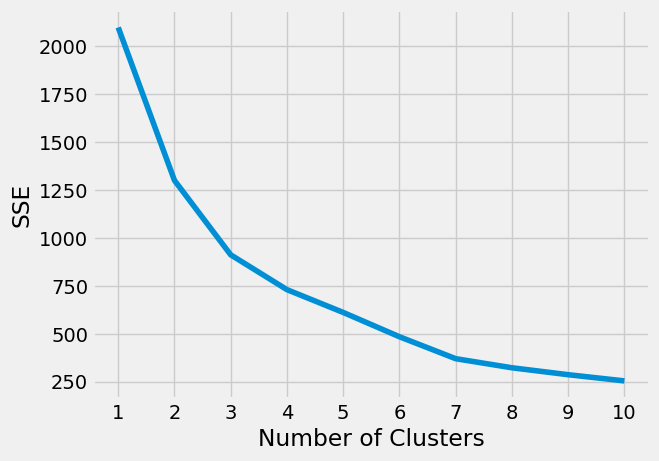

In [ ]:
import matplotlib.pyplot as plt
sse = [] 
for i in range(1, 11): 
    cluster = BisectingKMeans(n_clusters = i, init = 'k-means++', n_init = 50, algorithm = "elkan", random_state = 50)
    cluster.fit(X) 
    sse.append(cluster.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
cluster = BisectingKMeans(n_clusters = 7, init = 'k-means++', n_init = 50, algorithm = "elkan", random_state = 50).fit(X)
clustered_X_train, clustered_X_test = cluster.transform(X_train), cluster.transform(X_test)
base_estimator = sklearn.linear_model.SGDClassifier(loss = "log_loss", alpha = 0.01, early_stopping = True)
wrapper_estimator = LinearBoostClassifier(base_estimator = base_estimator, n_estimators = 20, loss = "entropy", max_depth = None, min_samples_split = 10)
main_estimator= AdaBoostClassifier(estimator = wrapper_estimator)
main_model = cross_validate(main_estimator, clustered_X_train, y_train, cv = 3, return_train_score = True, return_estimator = True)

main_model["test_score"], main_model["train_score"]

(array([0.63934426, 0.6       , 0.61666667]),
 array([0.65      , 0.69421488, 0.72727273]))

In [ ]:
for i in range(3): print(classification_report(y_test, main_model.get("estimator")[i].predict(clustered_X_test), zero_division = 0))

              precision    recall  f1-score   support

           0       0.57      1.00      0.72        17
           1       1.00      0.33      0.50         3
           2       1.00      0.15      0.27        13

    accuracy                           0.61        33
   macro avg       0.86      0.50      0.50        33
weighted avg       0.78      0.61      0.52        33

              precision    recall  f1-score   support

           0       0.56      0.53      0.55        17
           1       1.00      0.33      0.50         3
           2       0.44      0.54      0.48        13

    accuracy                           0.52        33
   macro avg       0.67      0.47      0.51        33
weighted avg       0.55      0.52      0.52        33

              precision    recall  f1-score   support

           0       0.67      0.47      0.55        17
           1       1.00      0.33      0.50         3
           2       0.50      0.77      0.61        13

    accuracy        

In [ ]:
joblib.dump(cluster,  "/content/drive/MyDrive/HIDS 509/Project/Models/cluster.sav")
joblib.dump(main_model.get("estimator")[2],  "/content/drive/MyDrive/HIDS 509/Project/Models/wrapped.sav")

['/content/drive/MyDrive/HIDS 509/Project/Models/wrapped.sav']